In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bbc-fulltext-and-category/bbc-text.csv


# Importing required packages and data

In [2]:
# Number and dataframe manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Text preprocessing functions
from sklearn.feature_extraction.text import TfidfVectorizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# load dataset
bbc_df = pd.read_csv("/kaggle/input/bbc-fulltext-and-category/bbc-text.csv")

In [4]:
bbc_df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


<Axes: xlabel='category'>

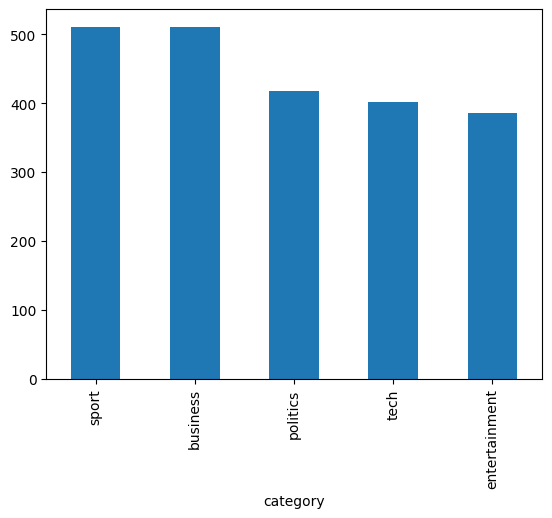

In [5]:
bbc_df['category'].value_counts().plot(kind = 'bar')

# Forming train, test datasets

In [6]:
# We want to detect specifically sport headlines
bbc_sport_df = bbc_df[bbc_df['category'] == 'sport'].reset_index(drop = True)

In [7]:
# Create Test, Train set

# Test should contain a mix of of classes
bbc_non_sport_df = bbc_df[bbc_df['category'] != 'sport'].reset_index(drop = True)

In [8]:
test_df = pd.DataFrame()

for category in bbc_non_sport_df['category'].unique():
    print(category)
    test_df = pd.concat( [test_df, bbc_non_sport_df[bbc_non_sport_df['category'] ==  category].head(100)], axis = 0)

tech
business
entertainment
politics


In [9]:
# manually remove 100 samples from train and add to test
np.random.seed(42)

sport_samples = bbc_sport_df.sample(100)


test_df = pd.concat([test_df, sport_samples], axis = 0)

# drop these from sport df
bbc_sport_df_rows_dropped = bbc_sport_df.drop(list(sport_samples.index)).reset_index(drop = True)

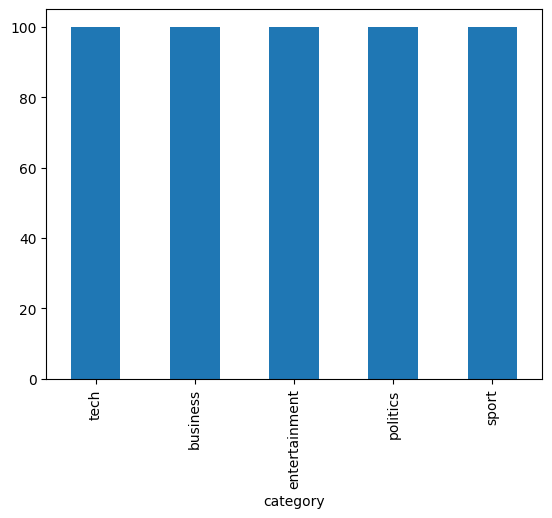

In [10]:
test_df['category'].value_counts().plot(kind = 'bar')
plt.show()

In [11]:
bbc_sport_df_rows_dropped['text'].duplicated().sum()

6

In [12]:
bbc_df['category'].value_counts(normalize = True)

category
sport            0.229663
business         0.229213
politics         0.187416
tech             0.180225
entertainment    0.173483
Name: proportion, dtype: float64

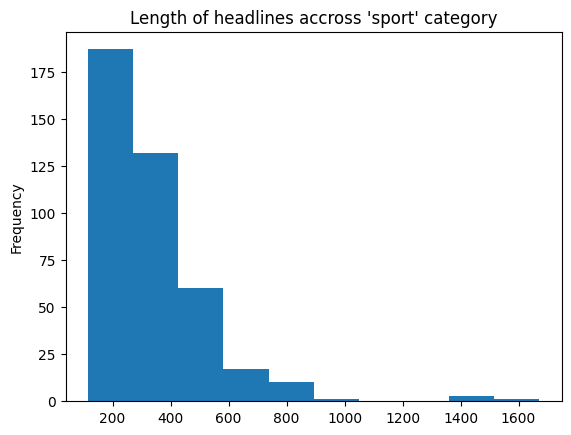

Min length (words): 116
Max length (words): 1671


In [13]:
bbc_sport_df_rows_dropped['text'].apply(lambda x: len(x.split())).plot(kind = 'hist')
plt.title("Length of headlines accross 'sport' category")
plt.show()

print(f"Min length (words): {bbc_sport_df_rows_dropped['text'].apply(lambda x: len(x.split())).min()}")
print(f"Max length (words): {bbc_sport_df_rows_dropped['text'].apply(lambda x: len(x.split())).max()}")

In [14]:
# Vectorizing using TFIDF
tfidf_vect = TfidfVectorizer(strip_accents= 'ascii')
sport_tfidf_matrix = tfidf_vect.fit_transform(bbc_sport_df_rows_dropped['text'])

In [15]:
# lots of features
sport_tfidf_matrix.shape

(411, 9540)

# Training with TFIDF Alone

In [16]:
from sklearn.svm import OneClassSVM


clf = OneClassSVM(nu = .22)
clf.fit(sport_tfidf_matrix)

OneClassSVM(nu=0.22)

In [17]:
def dataset_inference(test_df, clf, vectorizer, vectorizer_method = 'tfidf'):
    
    if vectorizer_method == 'tfidf':
        vectorized_features = vectorizer.transform(test_df['text'])
        
    elif vectorizer_method == 'embeddings':
        vectorized_features = vectorizer.encode(test_df['text'].to_list())
        
    return clf.predict(vectorized_features)

In [18]:
def convert_category_label_to_occ(label):
    if 'sport' in label:
        return 1
    else:
        return -1

In [19]:
y_hat_train = dataset_inference(bbc_sport_df_rows_dropped, clf, tfidf_vect)
y_true_train = bbc_sport_df_rows_dropped['category'].apply(convert_category_label_to_occ)

In [20]:
y_hat = dataset_inference(test_df, clf, tfidf_vect)
y_true = test_df['category'].apply(convert_category_label_to_occ)

In [21]:
y_hat.shape, y_true.shape

((500,), (500,))

In [22]:
from sklearn.metrics import classification_report
train_classification_report = pd.DataFrame(classification_report(y_true_train, y_hat_train, output_dict = True))
test_classification_report =pd.DataFrame(classification_report(y_true, y_hat, output_dict = True))

display('TRAIN', train_classification_report)
display('TEST:', test_classification_report)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

'TRAIN'

,-1,1,accuracy,macro avg,weighted avg
precision,0.0,1.000000,0.720195,0.500000,1.000000
recall,0.0,0.720195,0.720195,0.360097,0.720195
f1-score,0.0,0.837341,0.720195,0.418670,0.837341
support,0.0,411.000000,0.720195,411.000000,411.000000


'TEST:'

,-1,1,accuracy,macro avg,weighted avg
precision,0.832599,0.227106,0.502,0.529853,0.711501
recall,0.472500,0.620000,0.502,0.546250,0.502000
f1-score,0.602871,0.332440,0.502,0.467655,0.548785
support,400.000000,100.000000,0.502,500.000000,500.000000


# Attempting with Transformer Embeddings

In [23]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=33cbd9d7b90ce2ed10ce7ac9f85b5b6140a62ee1d3eae6da9997da56517b47d1
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [24]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [25]:
# Create train encodings
train_emebeddings = model.encode(bbc_sport_df_rows_dropped['text'])

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [26]:
# Fitting model on transformer embeddings
clf.fit(train_emebeddings)

OneClassSVM(nu=0.22)

In [27]:
# train inference
y_hat_train = clf.predict(train_emebeddings)
y_true_train = bbc_sport_df_rows_dropped['category'].apply(convert_category_label_to_occ).to_list()

In [28]:
# Test inference
y_hat = dataset_inference(test_df, clf, model, vectorizer_method = 'embeddings')
y_true = test_df['category'].apply(convert_category_label_to_occ).to_list()

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [29]:
from sklearn.metrics import classification_report
train_classification_report = pd.DataFrame(classification_report(y_true_train, y_hat_train, output_dict = True))
test_classification_report =pd.DataFrame(classification_report(y_true, y_hat, output_dict = True))

display('TRAIN', train_classification_report)
display('TEST:', test_classification_report)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'TRAIN'

,-1,1,accuracy,macro avg,weighted avg
precision,0.0,1.000000,0.746959,0.500000,1.000000
recall,0.0,0.746959,0.746959,0.373479,0.746959
f1-score,0.0,0.855153,0.746959,0.427577,0.855153
support,0.0,411.000000,0.746959,411.000000,411.000000


'TEST:'

,-1,1,accuracy,macro avg,weighted avg
precision,0.921659,1.000000,0.932,0.960829,0.937327
recall,1.000000,0.660000,0.932,0.830000,0.932000
f1-score,0.959233,0.795181,0.932,0.877207,0.926422
support,400.000000,100.000000,0.932,500.000000,500.000000


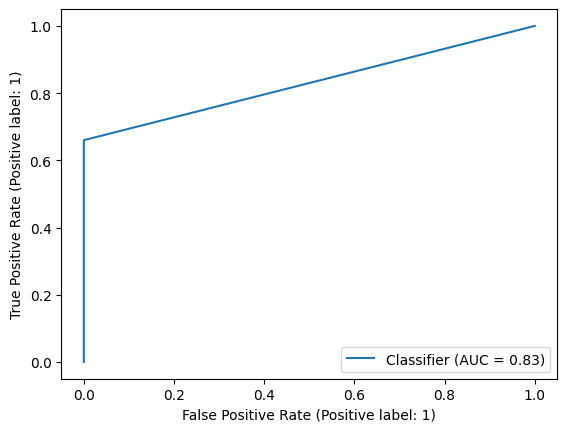

In [30]:
from sklearn.metrics import RocCurveDisplay

roc = RocCurveDisplay.from_predictions(y_true, y_hat)
plt.show()